## What is a Lag plots

A lag plot is simply a scatter plot where we plot $y_t$ against a lagged version of itself $y_{t-k}$. A helpful function in Pandas, `pd.plotting.lag_plot`, allows us to do this from a given series. 

## How do we choose Lags 
* #### Domain knowledge
* #### Feature Selection and modeling
* #### Timeseries correlation

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations, plot_acf, plot_lags, plot_pacf, plot_series, plot_windows

## Trend and seasonality: Retail sales example

#### Data Set Synopsis

The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes. 

a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

In [30]:
df = pd.read_csv('../../Datasets/example_retail_sales.csv', parse_dates=['ds'], index_col=['ds'])
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


In [45]:
plot_series(df['y'])
plt.xticks(rotation=20);

<img src='./plots/retail-sales-plot.png'>

* We can see both trend and seasonality in the data
* We can predict future values of target variable using past values of target variable
* We can create multiple lag features with different lags 

### Problem is which lags to use and how many lag features to create ?


#### When lagging the target  variable (`y`)
* ##### If seasonality is known use a lag of same seasonal order
    * Example 1 : monthly data with yearly seasonality 
        * Retail sales - yearly seasonality - use lag=12
    * Example 2 : Multiple seasonality
        * Electricity consumption data -- multiple season -- use multipe lags
        


*   ##### Most recent values tend to be more predictive
    * Example 1 : Retail sales data
        * Sales yesterday has more correlation with sales today
    * Example 2 : Electricity demand data
        * Demand a hour ago will have high correaltion with demand this hour 

### When using the feature variables (`X`) for lag-variables
* #### Use a subset of most important features that affects the target
* #### Use domain knowledge
* #### Example : retail sales 
    * Advertizement-spend is a useful feature in retail-sales forecasting
    * We can take lags of Advertizement-spending
    * We know that the Adverstize-spending of this month has an influence in the current sales
    * We can take the Adverstize-spending of previous months as a lag feature to predict sales this month

### What is not a good Lag feature?
Suppose Retail sale forecast and we have `is_weekend` as a feature. Taking lags of `is_weekend` is not very useful. Because knowing whether yesterday or day-before yesterday was a weekend is not very helpful. 

### Avoid data leakage 
* Only use the feature that you know at the predict time.
* Example : Retail sales
    * If we don't know the value of advertize spending in the future - use lags 
* When we lag a feature , most recent lags tend to be more predictive
    * Advertise spending in recent month are more useful than advertise spending from previous year

In [48]:
df.plot(y=['y'], figsize=(15,4))

<img src='./plots/retail-sales-plot.png'>



There is information in this data 
* Lets create lag plots and observe the correlation
    * We have monthly data with yearly seasonality 
    * Lets create lag plots up to lag=12 observer 

In [58]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
ax = ax.ravel()
for i, frame in enumerate(ax):
    pd.plotting.lag_plot(series=df['y'], lag=i+1, ax=frame)
    frame.set_xticks(frame.get_xticks())
    frame.set_xticklabels(frame.get_xticks(), rotation=45)


fig.suptitle('The lags \nIf data has a strong seasonal period then use the seasonal period as the lag\nWe can see a very good correlation when lag=12, this is because our data has a period of 12\n', fontsize=16)

plt.tight_layout();

<img src='./plots/lag-plot-and-seasonality.png'>

### Due to the strong trend component in the time series we see that the sales time series is strongly correlated with itself at many different lags. 

### The yearly seasonality is seen, in the very strong correlation, in the Lag 12 plot. As we would expect, this suggests a lag of 12 would be a useful feature.


### We expect the correlation to be greater with a shorter lag (more recent in time) than a larger lag (more distant in time).


####  We check this below by comparing the lag plot for `lag=1` month and `lag=100` months.

In [82]:
plot_lags(series=df['y'], lags=[1,100], suptitle='Plot of series against lags 1 and 100');

<img src='./plots/shorter-lag-more-corr.png'>

In [83]:
plot_lags(series=df['y'], lags=[12,100], suptitle='Plot of series against lags 12 and 100');

<img src='./plots/lag-plot-12-vs-100-shorter-lag-more-info.png'>

### We can see that the scatter plot is more spread out for a lag of 100 compared to a lag of 1 as expected. 

### But we still see a strong correlation. Why is this? 

### It is due to the strong trend component. This can be more clearly understood by plotting the original timeseries and lagged timeseries together. 

<AxesSubplot:>

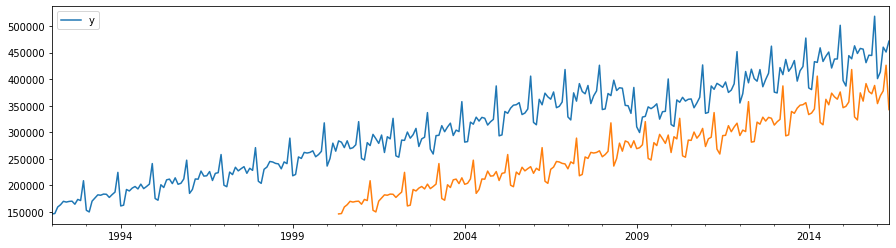

In [78]:
lag_100 = df['y'].shift(periods=100)

ax = df.plot(y=['y'], figsize=(15,4))
lag_100.plot(ax=ax)

### Visually it is clear that these two timeseries are highly correlated. 

### When one has low magnitude so does the other, when one has a high magnitude so does the other. This is why even at large lags we see high autocorrelation in the presence of a strong trend. 
### Summary
* We can examine lag plots to sense check and select useful lags. 
* We also have shown that just because the autocorrelation is high for large lags does not mean we should use large lags as features. 
* By examining the autocorrelation and partial autocorrelation function, we shall see that a lower order lags will contribute the most information. 
* Also using our own understanding of the domain we can rule out that the exact sales 100 months in the past should not have much of an effect on the sales in the present.

## White noise

lets create white noise and use lag-plots to show that there is no information in white-noise

In [5]:
num_timesteps = 300

rng = np.random.RandomState(seed=42)

noise = rng.normal(size=num_timesteps)

date_index = pd.date_range(start='2022-01-01', periods=num_timesteps)

df = pd.DataFrame(data={'noise': noise}, index=date_index)

In [9]:
plot_lags(series=df['noise'], lags=1);

<img src='./plots/lag-plot-whitenoise.png'>

### Lets plot many lags 

In [24]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10,10))
ax = ax.ravel()
for i, frame in enumerate(ax):
    pd.plotting.lag_plot(series=df['noise'], lag=i+1, ax=frame)


fig.suptitle('We see a bunch of blobs with no particular structure.\n This suggests that none of the lags shown above will be helpful for forecasting.\n', fontsize=16)

plt.tight_layout()


<img src='./plots/white-noise-has-no-info.png'>